<a href="https://colab.research.google.com/github/ljs7463/AnalysisProject/blob/master/%EA%B0%9C%EC%9D%B8%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/3.%20VideoGame_analysis/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분석의 목적(문제 정의) : 다음 분기에 어떤 게임을 설계해야 좋을지 인사이트 뽑기

 데이터 선정이유 : 취업을 했을때 회사가 항상 좋은 상황만 있는것은 아닐것이다. 
  기술의 발전으로 비디오 게임 수요가 급락한 가운데 내가 만약 비디오게임 시장의 한가운데에 있는 회사의 직원이라면 분석가로서 어떻게 의사결정권자에게 도움을 주고 돌파구를 찾을지 스스로 상황을 만들어 해결해 보고싶어서 하게되었다.

## 사전설정(필수)

In [99]:
# matplotlib 버전 upgrade
!pip install matplotlib -U
import matplotlib as mpl
mpl.__version__             

'3.4.3'

In [100]:
!sudo apt-get install -y fonts-nanum  # 오픈폰트인 나눔폰트 설치
!sudo fc-cache -fv # matplotlib에 자체적으로 캐싱을 하고있는데 안에 폰트파일이 포함되어 있다 그래서 이 캐싱파일에 업데이트 되야 나눔폰트 설치한걸 인식해서 다 날려줌
!rm ~/.cache/matplotlib -rf # 설치한 나눔폰트를 적용


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [101]:
pip install category_encoders

다시시작 모두실행 꼭 실시하기

In [102]:
# 나눔바른고딕체 적용
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 


## 데이터 탐색

In [103]:
# 필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler 
from category_encoders import OneHotEncoder

In [104]:
# 생성한 함수

# 1. 단위 변환 함수
def convert(column):
  for i in range(len(column)):
    if (str(type(column[i]))=="<class 'str'>"):
      if (column[i].find('K') != -1):
        column[i] = re.sub('K','',column[i])
        column[i] = float(column[i])
        column[i] *= 0.001
      elif (column[i].find('M') != -1):
        column[i] = re.sub('M','',column[i])
        column[i] = float(column[i])
  return column


# 2. 이상치 확인 함수
def find_outlier_by_Tukey(data):
  q1, q3 = np.percentile(data,[25, 75])

  iqr = q3 - q1

  lower_bound = q1 - (iqr * 1.5) # Q1 - (iqr * 1.5)
  upper_bound = q3 + (iqr * 1.5) # Q1 + (iqr * 1.5)

  mask = np.where((data > upper_bound) | (data < lower_bound))

  return mask

In [105]:
# 데이터 로드
dataset = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv')
dataset= dataset.drop('Unnamed: 0', axis = 1)
dataset.head(60)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
5,Power Pro Kun Pocket 8,DS,2005.0,Sports,Konami Digital Entertainment,0,0,0.14,0
6,JASF: Jane's Advanced Strike Fighters,PC,2011.0,Simulation,Deep Silver,0.02,0.01,0,0
7,Samurai Warriors: State of War,PSP,2005.0,Action,Tecmo Koei,0.07,0,0.11,0.01
8,Imabikisou,PS3,2007.0,Adventure,Sega,0,0,0.04,0
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011.0,Action,THQ,0.04,0.03,0,0.01


- Name : 게임의 이름입니다.
- Platform : 게임이 지원되는 플랫폼의 이름입니다.
- Year : 게임이 출시된 연도입니다.
- Genre : 게임의 장르입니다.
- Publisher : 게임을 제작한 회사입니다.
- NA_Sales : 북미지역에서의 출고량입니다.
- EU_Sales : 유럽지역에서의 출고량입니다.
- JP_Sales : 일본지역에서의 출고량입니다.
- Other_Sales : 기타지역에서의 출고량입니다.

< 데이터 타입 확인 >

명목형(Nominal) : Name, Platform, Genre, Publisher

순서형(Ordinal) :

이산형(Discrete) : Year

연속형(Continuous) : NA_Sales, EU_Sales, JP_Sales, Other_Sales

In [106]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [107]:
dataset.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [108]:
dataset['Year'].value_counts().tail()

14.0      2
13.0      2
94.0      1
2020.0    1
86.0      1
Name: Year, dtype: int64

Year 컬럼에 년도가 2자리인 값들이 분포해 있는것으로 확인

## 데이터 클리닝

### 결측값 처리

In [109]:
# 연도 자릿수 누락 데이터 전처리

Year =[]
for i in dataset['Year']:
  if i <= 20: # 연도가 20이하로 적혀있는것은 2000년대 
    Year.append(2000 + i)
  elif i <= 99: # 나머지 연도는 1900년대
    Year.append(1900 + i)
  else:
    Year.append(i)

Year

[2008.0,
 2009.0,
 2010.0,
 2010.0,
 2010.0,
 2005.0,
 2011.0,
 2005.0,
 2007.0,
 2011.0,
 2001.0,
 2003.0,
 2008.0,
 2005.0,
 2006.0,
 2009.0,
 2003.0,
 2014.0,
 2015.0,
 2009.0,
 2002.0,
 1997.0,
 2005.0,
 2014.0,
 2013.0,
 2002.0,
 1996.0,
 2011.0,
 2004.0,
 2000.0,
 2011.0,
 nan,
 2006.0,
 2015.0,
 2004.0,
 2009.0,
 2005.0,
 1984.0,
 2008.0,
 2006.0,
 2000.0,
 2004.0,
 2007.0,
 2008.0,
 2013.0,
 2015.0,
 1998.0,
 2002.0,
 2008.0,
 2009.0,
 2005.0,
 2009.0,
 2001.0,
 2009.0,
 2009.0,
 2010.0,
 2016.0,
 2010.0,
 2010.0,
 1985.0,
 2006.0,
 2008.0,
 2010.0,
 2011.0,
 2004.0,
 1998.0,
 2011.0,
 2004.0,
 2014.0,
 2010.0,
 1999.0,
 2007.0,
 2015.0,
 2003.0,
 2009.0,
 2010.0,
 1985.0,
 2000.0,
 2007.0,
 2008.0,
 2005.0,
 1997.0,
 1997.0,
 2003.0,
 2000.0,
 2003.0,
 1995.0,
 2005.0,
 2010.0,
 1999.0,
 2010.0,
 2005.0,
 2011.0,
 2014.0,
 2003.0,
 1998.0,
 2011.0,
 2001.0,
 2010.0,
 1993.0,
 2014.0,
 2009.0,
 2002.0,
 2004.0,
 2005.0,
 2007.0,
 2005.0,
 2000.0,
 2016.0,
 nan,
 2012.0,
 2007.0

In [110]:
# Year 적용하기
dataset['Year'] = pd.Series(Year)
dataset['Year']

0        2008.0
1        2009.0
2        2010.0
3        2010.0
4        2010.0
          ...  
16593    2006.0
16594    2005.0
16595    2015.0
16596    2013.0
16597    1996.0
Name: Year, Length: 16598, dtype: float64

Year를 포함하여 전체 데이터 수 대비 결측값이 너무 작다고 생각되어 파이차트로 검토해 보기

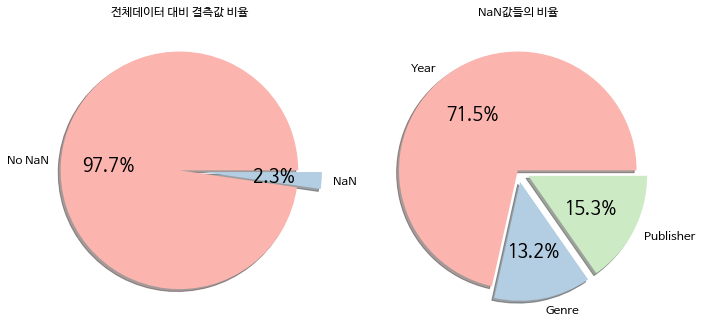

In [111]:
# figure기본 옵션 세팅
sns.set_context('notebook')
sns.set_palette('Pastel1')

# subplots만들기
fig, ax = plt.subplots(1,2,figsize =(10,5))


# 첫 번째 pie차트 만들기
sizes1 = [16219/16598, 379/16598]
labels1 = ['No NaN','NaN']

pathes, texts, autotexts = ax[0].pie(sizes1,
                                   labels = labels1,
                                   autopct ='%1.1f%%',
                                   shadow = True,
                                   explode = (0, 0.2))

for t in texts:
  t.set_fontsize(12)
  t.set_color('black')

for t in autotexts:
  t.set_color('black')
  t.set_fontsize(18)

ax[0].set_title('전체데이터 대비 결측값 비율')



# 두 번째 파이차트 만들기
sizes2 = [271/379, 50/379, 58/379]
labels2 = ['Year','Genre', 'Publisher']

pathes, texts, autotexts = ax[1].pie(sizes2,
                                   labels = labels2,
                                   autopct ='%1.1f%%',
                                   shadow = True,
                                   explode = (0, 0.1,0.1))

for t in texts:
  t.set_fontsize(12)
  t.set_color('black')

for t in autotexts:
  t.set_color('black')
  t.set_fontsize(18)

ax[1].set_title('NaN값들의 비율')

plt.tight_layout()
plt.show()

NaN값을 비교해 봤더니 전체데이터 대비 NaN값이 2.3% 밖에 되지 않고, 극소수의 NaN값들 안에서도 "Genre"와 "Publisher"는  극히 일부이므로 NaN값을 처리하는데 있어서 drop을 해주는것이 좋다고 판단했다. 극히 일부의 NaN값을 위해 결측값처리의 방법론을 활용하여 넣어준다해도 오차가 생기는데 이러한 데이터 결측처리를 위해서 오차를 허용하면서 할 필요성을 느끼지 못하여 과감하게 drop해준다.

반면 Year역시 전체데이터와 비교했을때 극히 일부의 데이터에 불과하지만 "Genre"와 "Publisher" 를 같이 비교했을땐 비중이 높다 하지만 앞에서 이 둘을 drop처리했기때문에 같이 drop처리를 해준다.

(아주 작은데이터 라도 무시할 수 없지만 극히 일부의 데이터를 위해 필요이상의 시간을 낭비하는것 또한 비효율이라고 생각했다.)

Year, Genre, Publisher 전처리

In [112]:
# Year, Genre, Publisher 세개의 feature에 빈값이 있는 행 제거
dataset = dataset.dropna(subset = ['Genre', 'Publisher', 'Year'], axis = 0, how = 'any')

In [113]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16241 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16241 non-null  object 
 1   Platform     16241 non-null  object 
 2   Year         16241 non-null  float64
 3   Genre        16241 non-null  object 
 4   Publisher    16241 non-null  object 
 5   NA_Sales     16241 non-null  object 
 6   EU_Sales     16241 non-null  object 
 7   JP_Sales     16241 non-null  object 
 8   Other_Sales  16241 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.2+ MB


In [114]:
# Year데이터 int형 변환
dataset['Year'] =dataset['Year'].astype(int)
dataset['Year']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        2008
1        2009
2        2010
3        2010
4        2010
         ... 
16593    2006
16594    2005
16595    2015
16596    2013
16597    1996
Name: Year, Length: 16241, dtype: int64

In [115]:
dataset.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

In [116]:
# 대륙별 출고량 데이터 확인하기
dataset.iloc[:,5:].head(50)

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,0.04,0,0,0
1,0.17,0,0,0.01
2,0,0,0.02,0
3,0.04,0,0,0
4,0.12,0.09,0,0.04
5,0,0,0.14,0
6,0.02,0.01,0,0
7,0.07,0,0.11,0.01
8,0,0,0.04,0
9,0.04,0.03,0,0.01


In [117]:
# (Index가 random하게 섞여있어) "Keyerror" 해결을 위한 index 재설정
dataset = dataset.reset_index()
dataset = dataset.drop('index',axis = 1)
dataset.iloc[:,5:].head(50)

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,0.04,0,0,0
1,0.17,0,0,0.01
2,0,0,0.02,0
3,0.04,0,0,0
4,0.12,0.09,0,0.04
5,0,0,0.14,0
6,0.02,0.01,0,0
7,0.07,0,0.11,0.01
8,0,0,0.04,0
9,0.04,0.03,0,0.01


In [118]:
# 데이터 단위 및 타입 변환(convert함수 사용)
dataset['NA_Sales'] = pd.to_numeric(convert(dataset['NA_Sales']))
dataset['EU_Sales'] = pd.to_numeric(convert(dataset['EU_Sales']))
dataset['JP_Sales'] = pd.to_numeric(convert(dataset['JP_Sales']))
dataset['Other_Sales'] = pd.to_numeric(convert(dataset['Other_Sales']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

In [119]:
# 단위및 타입변환 검정
dataset.head(50)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04
5,Power Pro Kun Pocket 8,DS,2005,Sports,Konami Digital Entertainment,0.00,0.00,0.14,0.00
6,JASF: Jane's Advanced Strike Fighters,PC,2011,Simulation,Deep Silver,0.02,0.01,0.00,0.00
7,Samurai Warriors: State of War,PSP,2005,Action,Tecmo Koei,0.07,0.00,0.11,0.01
8,Imabikisou,PS3,2007,Adventure,Sega,0.00,0.00,0.04,0.00
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011,Action,THQ,0.04,0.03,0.00,0.01


### 이상치 확인 및 처리


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NA_Sales'>

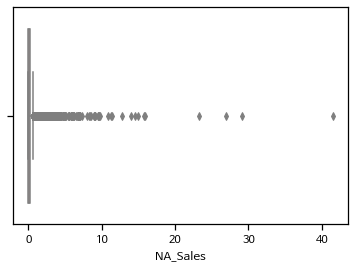

In [120]:
sns.boxplot(dataset['NA_Sales'])

In [121]:
# 이상치 확인 함수
find_outlier_by_Tukey(dataset['NA_Sales'])

(array([   90,   105,   119, ..., 16217, 16227, 16234]),)

In [122]:
dataset['NA_Sales'][find_outlier_by_Tukey(dataset['NA_Sales'])[0]].index

Int64Index([   90,   105,   119,   123,   146,   152,   162,   179,   189,
              220,
            ...
            16160, 16176, 16183, 16189, 16190, 16191, 16197, 16217, 16227,
            16234],
           dtype='int64', length=1650)

출고량 데이터의 이상치의 발생요인을 세가지로 정리 해 보았다.

1. 독보적인 인기로 인한 이상치
2. 단위 오류로 인한 이상치 발생(Ex)'K'의 누락)
3. 데이터 수집 과정에서의 문제

In [123]:
# 예시로 북미의 인기있는 데이터를 살펴보았다.
dataset.sort_values('NA_Sales',ascending=False).head(50)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
2855,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46
4113,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77
10280,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47
1187,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58
12316,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31
3288,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96
4253,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67
16176,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26
2959,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85
12837,Super Mario World,SNES,1990,Platform,Nintendo,12.78,3.75,3.54,0.55


메가히트작을 아웃라이어로 제거 하는 것 보다 따로 데이터를 나누어 메가히트작의 특징을 분석해 보고 일반 작품의 특성과 비교를 해봄으로서 새로운 인사이트를 도출 해 보자

즉 데이터를 각 지역별 메가히트작 4개의 데이터 프레임과 전체 데이터프레임1개
해서 총 5개의 데이터프레임을 분포시킨다.

In [124]:
Megahit_NA = dataset['NA_Sales'][find_outlier_by_Tukey(dataset['NA_Sales'])[0]].index # 북미
Megahit_EU = dataset['EU_Sales'][find_outlier_by_Tukey(dataset['EU_Sales'])[0]].index # 유럽
Megahit_JP = dataset['JP_Sales'][find_outlier_by_Tukey(dataset['JP_Sales'])[0]].index # 일본
Megahit_Other = dataset['Other_Sales'][find_outlier_by_Tukey(dataset['Other_Sales'])[0]].index # 다른국가

In [125]:
# 북미
Megahit_N = []

for i in Megahit_NA:
  Megahit_N.append(i)

Megahit_N 


# 유럽
Megahit_E = []

for i in Megahit_EU:
  Megahit_E.append(i)

Megahit_E 


# 일본
Megahit_J = []

for i in Megahit_JP:
  Megahit_J.append(i)

Megahit_J 

# 다른국가
Megahit_O = []

for i in Megahit_Other:
  Megahit_O.append(i)

Megahit_O 

[20,
 24,
 105,
 119,
 123,
 162,
 164,
 189,
 190,
 220,
 237,
 256,
 287,
 329,
 333,
 338,
 371,
 372,
 378,
 437,
 438,
 448,
 450,
 466,
 478,
 479,
 482,
 483,
 491,
 494,
 503,
 511,
 514,
 529,
 531,
 553,
 560,
 561,
 568,
 577,
 586,
 593,
 594,
 595,
 612,
 613,
 619,
 623,
 630,
 653,
 663,
 672,
 673,
 689,
 726,
 735,
 745,
 751,
 758,
 768,
 784,
 787,
 835,
 836,
 858,
 906,
 923,
 925,
 937,
 948,
 950,
 956,
 959,
 966,
 973,
 992,
 1000,
 1017,
 1021,
 1030,
 1031,
 1033,
 1059,
 1082,
 1086,
 1091,
 1101,
 1124,
 1131,
 1143,
 1150,
 1154,
 1164,
 1187,
 1204,
 1222,
 1223,
 1234,
 1242,
 1244,
 1254,
 1263,
 1266,
 1282,
 1290,
 1292,
 1294,
 1298,
 1304,
 1338,
 1343,
 1352,
 1353,
 1364,
 1378,
 1391,
 1392,
 1401,
 1405,
 1418,
 1469,
 1485,
 1489,
 1490,
 1513,
 1516,
 1544,
 1549,
 1554,
 1575,
 1582,
 1586,
 1591,
 1599,
 1601,
 1606,
 1610,
 1636,
 1647,
 1677,
 1701,
 1734,
 1745,
 1766,
 1780,
 1810,
 1822,
 1842,
 1851,
 1862,
 1872,
 1877,
 1881,
 1892,


In [126]:
# 북미
Megadata_NA = []
for i in Megahit_N:
  Megadata_NA.append(dataset.iloc[i,:])
# 유럽
Megadata_EU = []
for i in Megahit_E:
  Megadata_EU.append(dataset.iloc[i,:])
# 일본
Megadata_JP = []
for i in Megahit_J:
  Megadata_JP.append(dataset.iloc[i,:])
  
# 다른지역
Megadata_Other = []
for i in Megahit_O:
  Megadata_Other.append(dataset.iloc[i,:])


In [127]:
# 북미
Megadata_NA = pd.DataFrame(Megadata_NA)
Megadata_NA = Megadata_NA.reset_index()
Megadata_NA = Megadata_NA.drop('index', axis =1)
Megadata_NA
# 유럽
Megadata_EU = pd.DataFrame(Megadata_EU)
Megadata_EU = Megadata_EU.reset_index()
Megadata_EU = Megadata_EU.drop('index', axis =1)
Megadata_EU
# 일본
Megadata_JP = pd.DataFrame(Megadata_JP)
Megadata_JP = Megadata_JP.reset_index()
Megadata_JP = Megadata_JP.drop('index', axis =1)
Megadata_JP
# 다른국가 
Megadata_Other = pd.DataFrame(Megadata_Other)
Megadata_Other = Megadata_Other.reset_index()
Megadata_Other = Megadata_Other.drop('index', axis =1)
Megadata_Other


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Ty the Tasmanian Tiger,PS2,2002,Platform,Electronic Arts,0.57,0.45,0.00,0.15
1,Injustice: Gods Among Us,PS3,2013,Fighting,Warner Bros. Interactive Entertainment,0.48,0.53,0.01,0.23
2,Madden NFL 2001,PS2,2000,Sports,Electronic Arts,1.19,0.07,0.05,0.20
3,Call of Duty 4: Modern Warfare,X360,2007,Shooter,Activision,5.91,2.38,0.13,0.90
4,Mortal Kombat,PS3,2011,Fighting,Warner Bros. Interactive Entertainment,1.98,0.55,0.00,0.32
...,...,...,...,...,...,...,...,...,...
1631,Left 4 Dead,X360,2008,Shooter,Electronic Arts,2.66,0.50,0.05,0.30
1632,Wall-E,Wii,2008,Platform,THQ,0.51,0.40,0.00,0.11
1633,Finding Nemo,PS2,2003,Action,THQ,1.26,0.60,0.05,0.18
1634,LEGO Indiana Jones 2: The Adventure Continues,Wii,2009,Action,Activision,0.91,0.39,0.00,0.13


< 현재 생성된 데이터 프레임 정리 >

원본 데이터 프레임 : dataset

미국 인기 출고량 데이터 프레임 : Megadata_NA

유럽 인기 출고량 데이터 프레임 : Megadata_EU

일본 인기 출고량 데이터 프레임 : Megadata_JP

다른지역 인기 출고량 데이터 프레임 : Megadata_Other

## EDA

### 지역에 따라서 선호하는 게임 장르가 다를까?

#### 상관관계 검정


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


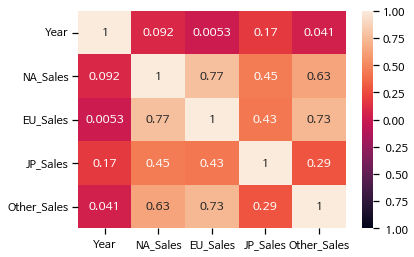

In [128]:
# 출고량과 지역간의 상관관계 (선호도 = 출고량)
sns.set_context('notebook');

sns.heatmap(abs(dataset.corr()),vmin = -1, vmax = 1,annot = True); # 절대값을 사용한 이유는 방향보다 단순 power만 확인하기위해

"북미와 유럽" 의 출고량과 "유럽과 기타다른지역" 과의 출고량이 70% 이상의 상관관계를 나타내고 있다. 

#### 시각화 검정

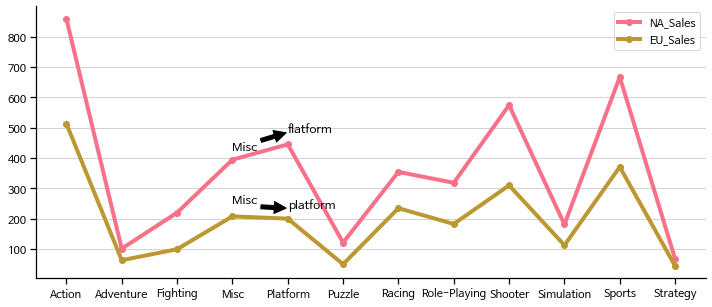

In [129]:
# 북미와 유럽 데이터 비교
sns.set_context('notebook')
sns.set_palette('husl')
fig, ax= plt.subplots(figsize = (12, 5))

region = ['NA_Sales', 'EU_Sales']

for i in region:
  ax.plot(dataset.groupby('Genre')[i].sum(),'o-',label = i,lw = 4)

ax.grid(axis="y", c="lightgray")
ax.spines[[ "top", "right"]].set_visible(False)

plt.text('Platform',235, 'platform')
plt.annotate('Misc', xy=('Platform',235), xytext=('Misc',250), arrowprops=dict(facecolor='black', shrink=0.05))

plt.text('Platform',485, 'flatform')
plt.annotate('Misc', xy=('Platform',485), xytext=('Misc',425), arrowprops=dict(facecolor='black', shrink=0.05))


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['NA_Sales','EU_Sales'])
plt.legend()

북미와 유럽시장에서는 Platform을 제외하고는 선호도 순위가 비슷하다.

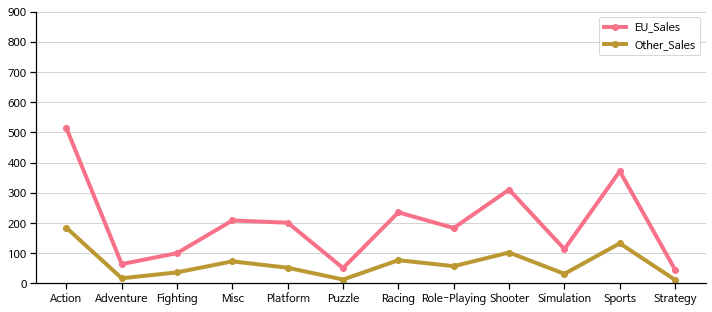

In [130]:
# 유럽과 기타지역 데이터 비교
sns.set_context('notebook')
sns.set_palette('husl')

fig, ax= plt.subplots(figsize = (12, 5))

region = ['EU_Sales', 'Other_Sales']

for i in region:
  ax.plot(dataset.groupby('Genre')[i].sum(),'o-',label = i,lw = 4)
  ax.set_ylim(0, 900)

ax.grid(axis="y", c="lightgray")
ax.spines[[ "top", "right"]].set_visible(False)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['EU_Sales','Other_Sales'])
plt.legend()

유럽과 기타다른지역간의 선호도 순위 또한 비슷한 것으로 집계되었다.


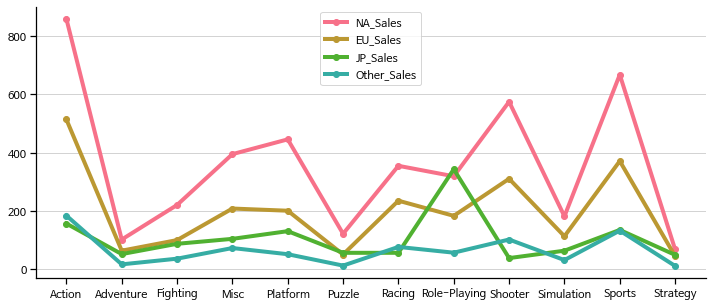

In [131]:
# 4개 지역 데이터 비교
sns.set_context('notebook')
sns.set_palette('husl')

fig, ax= plt.subplots(figsize = (12, 5))

region = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for i in region:
  ax.plot(dataset.groupby('Genre')[i].sum(),'o-',label = i,lw = 4)

ax.grid(axis="y", c="lightgray")
ax.spines[[ "top", "right"]].set_visible(False)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
plt.legend()

일본은 다른장르에 비해 Role-Playing이 월등하다. 좀 더 자세하게 확인해 보기 위해 가장 선호도 높은 5개의 장르를 지역별로 추출해 보자

In [132]:
# 지역별 Top5 값과 라벨 뽑기(추후 코드 고도화작업하기)

NA_Top = dataset.groupby('Genre')['NA_Sales'].sum().sort_values(ascending = False).iloc[:5].values
NA_Top = NA_Top.tolist()

EU_Top = dataset.groupby('Genre')['EU_Sales'].sum().sort_values(ascending = False).iloc[:5].values
EU_Top  = EU_Top .tolist()

JP_Top = dataset.groupby('Genre')['JP_Sales'].sum().sort_values(ascending = False).iloc[:5].values
JP_Top = JP_Top.tolist()

Other_Top = dataset.groupby('Genre')['Other_Sales'].sum().sort_values(ascending = False).iloc[:5].values
Other_Top = Other_Top.tolist()


NA_Top_label = dataset.groupby('Genre')['NA_Sales'].sum().sort_values(ascending = False).iloc[:5].index
NA_Top_label = NA_Top_label.tolist()

EU_Top_label = dataset.groupby('Genre')['EU_Sales'].sum().sort_values(ascending = False).iloc[:5].index
EU_Top_label = EU_Top_label.tolist()

JP_Top_label = dataset.groupby('Genre')['JP_Sales'].sum().sort_values(ascending = False).iloc[:5].index
JP_Top_label = JP_Top_label.tolist()

Other_Top_label = dataset.groupby('Genre')['Other_Sales'].sum().sort_values(ascending = False).iloc[:5].index
Other_Top_label = Other_Top_label.tolist()

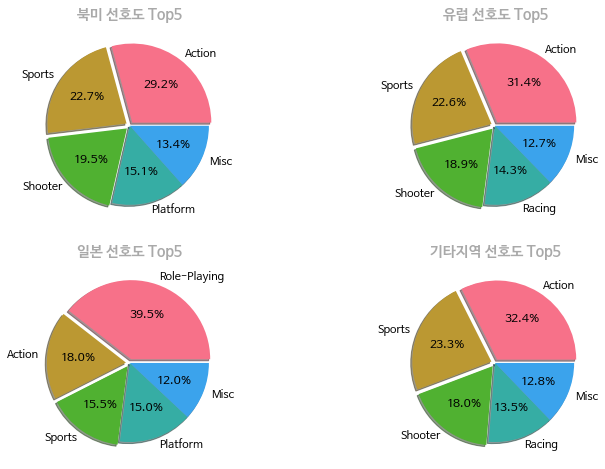

In [133]:
# 지역별 선호하는 장르 Top5
sns.set_context('notebook')
sns.set_palette('husl')

fig, ax = plt.subplots(2,2,figsize = (12,8))

pathes, texts, autotexts = ax[(0,0)].pie(NA_Top,
                                  labels = NA_Top_label,
                                  autopct = "%1.1f%%",
                                  shadow = True,
                                  explode = (0.05,0.05,0.05,0,0))
ax[(0,0)].set_title('북미 선호도 Top5',fontweight="bold", fontsize="large", color="darkgray", pad=8)

pathes, texts, autotexts = ax[(0,1)].pie(EU_Top,
                                  labels = EU_Top_label,
                                  autopct = "%1.1f%%",
                                  shadow = True,
                                  explode = (0.05,0.05,0.05,0,0))
ax[(0,1)].set_title('유럽 선호도 Top5',fontweight="bold", fontsize="large", color="darkgray", pad=8)

pathes, texts, autotexts = ax[(1,0)].pie(JP_Top,
                                  labels = JP_Top_label,
                                  autopct = "%1.1f%%",
                                  shadow = True,
                                  explode = (0.05,0.05,0.05,0,0))
ax[(1,0)].set_title('일본 선호도 Top5',fontweight="bold", fontsize="large", color="darkgray", pad=8)

pathes, texts, autotexts = ax[(1,1)].pie(Other_Top,
                                  labels = Other_Top_label,
                                  autopct = "%1.1f%%",
                                  shadow = True,
                                  explode = (0.05,0.05,0.05,0,0))
ax[(1,1)].set_title('기타지역 선호도 Top5',fontweight="bold", fontsize="large", color="darkgray", pad=8);

#### 통계검정


In [134]:
# 교차 분석을 위해 새롭게 테이블을 만들어 준다.
chi2 = dataset.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
chi2

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,858.75,513.64,156.60,183.99
Adventure,101.79,63.66,51.87,16.70
Fighting,220.35,99.90,87.14,36.15
Misc,394.73,208.15,104.18,72.64
Platform,445.38,200.63,130.53,51.45
Puzzle,121.58,50.47,56.24,12.44
Racing,354.70,235.02,56.32,76.51
Role-Playing,318.76,183.09,342.93,56.73
Shooter,574.48,310.23,38.18,101.86


In [135]:
# 교차테이블을 array형태로 만들어 준다.
obs = np.array(chi2)
obs

array([[858.75, 513.64, 156.6 , 183.99],
       [101.79,  63.66,  51.87,  16.7 ],
       [220.35,  99.9 ,  87.14,  36.15],
       [394.73, 208.15, 104.18,  72.64],
       [445.38, 200.63, 130.53,  51.45],
       [121.58,  50.47,  56.24,  12.44],
       [354.7 , 235.02,  56.32,  76.51],
       [318.76, 183.09, 342.93,  56.73],
       [574.48, 310.23,  38.18, 101.86],
       [181.43, 112.99,  63.54,  31.32],
       [667.26, 370.97, 134.76, 132.35],
       [ 67.83,  44.82,  49.1 ,  11.23]])

In [137]:
# 이원카이제곱검정 실시
from scipy.stats import chi2_contingency
chi2 = chi2_contingency(obs)
if chi2[1] < 0.05:
  print("장르와 지역은 서로 연관이 없다.")
else:
  print("장르와 지역은 서로 연관이 있다.")

장르와 지역은 서로 연관이 없다.


EDA 결과
- 카이제곱 검정을 통해 분포의 차이를 확인해 본 결과 지역과 게임장르는 서로 연관이 없다.(“지역별 장르의 차이는 없다” 라는 귀무가설이 우연히 맞을 확률이 거의 없다)

- 북미와 유럽시장의 선호도는 매우 비슷하다.Action과 Sports 두장르가 50% 이상을 차지하며 다른 점으로는 선호도 4번째 순위가 북미는 Platform이지만 유럽은 Racing이 차지하고 있다.

- 유럽과 기타지역들간의 선호도 집계 또한 매우 비슷하다. (특히 선호하는 Top5의 장르가 같으며, 그 비율 또한 오차범위 1%이내에서 똑같다,)

- 지역별 선호도 Top5를 뽑아본 결과 일본을 제외하고는 Action과 Sports가 50프로이상을 차지하고 있으며 일본은 Role-Playing이 다른 장르에 비해 압도적이다. 특히 다른 지역들에서 압도적으로 나타난 Action과 Sports를 합친것이 Role_Playing보다 작다는 결과이다.


### 연도별 게임의 트렌드가 있을까??

In [138]:
# 게임의 트렌드는 출고량으로 확인할 수 있다고 생각해서 전체 출고량을 나타내는 컬럼 생성.
Total_Sales = []
for i in range(16241):
  Total_Sales.append(dataset['NA_Sales'][i] + dataset['EU_Sales'][i] + dataset['JP_Sales'][i] + dataset['Other_Sales'][i])

Total_Sales

[0.04,
 0.18000000000000002,
 0.02,
 0.04,
 0.25,
 0.14,
 0.03,
 0.19,
 0.04,
 0.08,
 0.8700000000000001,
 0.19,
 0.02,
 0.02,
 0.02,
 0.36000000000000004,
 0.04,
 0.03,
 0.05,
 0.02,
 1.17,
 0.11,
 0.1,
 0.01,
 1.25,
 0.03,
 0.05,
 0.29000000000000004,
 0.08,
 0.26,
 0.05,
 0.16,
 0.01,
 0.59,
 0.44,
 0.3999999999999999,
 0.27,
 0.13,
 0.24,
 0.8600000000000001,
 0.03,
 0.67,
 0.05,
 0.93,
 0.33000000000000007,
 0.12,
 0.13,
 0.16999999999999998,
 0.25,
 0.19,
 0.07,
 0.7000000000000001,
 0.05,
 0.35,
 0.05,
 0.03,
 0.56,
 1.03,
 0.05,
 0.48000000000000004,
 0.29000000000000004,
 0.13,
 0.01,
 0.37,
 1.04,
 0.05,
 0.27,
 0.19,
 0.27,
 0.04,
 0.16000000000000003,
 0.29000000000000004,
 0.16,
 0.09,
 0.51,
 0.63,
 0.11,
 0.01,
 0.11,
 0.18000000000000002,
 0.15000000000000002,
 0.25,
 0.16,
 0.34,
 0.89,
 0.1,
 0.42,
 0.4,
 0.11000000000000001,
 0.18000000000000002,
 1.07,
 0.11,
 0.05,
 0.09000000000000001,
 0.02,
 0.76,
 0.6399999999999999,
 1.17,
 0.08,
 0.19,
 0.13,
 0.07,
 0.249999

In [140]:
# 컬럼 적용
dataset['Total_Sales'] = Total_Sales
dataset

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16237,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16239,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [141]:
# year가 2020인 행 지우기(잘못된 데이터)
year_delete = dataset[dataset['Year']==2020].index
dataset.drop(year_delete, inplace=True)

In [142]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16240 entries, 0 to 16240
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16240 non-null  object 
 1   Platform     16240 non-null  object 
 2   Year         16240 non-null  int64  
 3   Genre        16240 non-null  object 
 4   Publisher    16240 non-null  object 
 5   NA_Sales     16240 non-null  float64
 6   EU_Sales     16240 non-null  float64
 7   JP_Sales     16240 non-null  float64
 8   Other_Sales  16240 non-null  float64
 9   Total_Sales  16240 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.4+ MB


#### 연도별 게임의 출고량

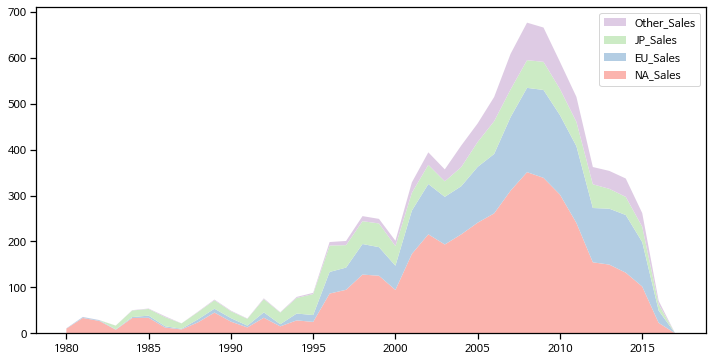

In [143]:
# 연도별 게임 출고량 시각화
sns.set_palette('Pastel1')
# 연도 기준 그룹핑
year_data = dataset.groupby('Year').sum()

# make subplots
fig, ax =plt.subplots(figsize = (12,6))
ax.stackplot(year_data.index, 
             year_data['NA_Sales'], 
             year_data['EU_Sales'],
             year_data['JP_Sales'], 
             year_data['Other_Sales'], 
             labels =['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

# stackplot의 특징을 고려하여 범례순서를 그림과 맞추어 주었다.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1], labels=labels[::-1])
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.get_legend_handles_labels.html

2005년에서 2010년 가장많은 출고량의 상승변화가 있었다.
이 기간에 무슨일이 있었는지 알아보자.

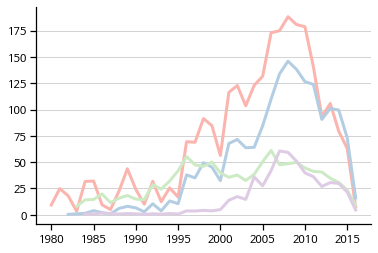

In [144]:
# 연도별 히트작 장르에 따른 출고량
fig, ax = plt.subplots()
sns.set_palette('husl')

ax.plot(Megadata_NA.groupby('Year')['NA_Sales'].sum(),lw = 3)
ax.plot(Megadata_EU.groupby('Year')['EU_Sales'].sum(),lw = 3)
ax.plot(Megadata_JP.groupby('Year')['JP_Sales'].sum(),lw = 3)
ax.plot(Megadata_Other.groupby('Year')['Other_Sales'].sum(),lw = 3)

ax.grid(axis="y", c="lightgray")
ax.spines[[ "top", "right"]].set_visible(False)

히트작품이 같은 기간에 출고량이 높아 전체 데이터 역시 동년도에 높은것으로 나온것이 확인되었다.

In [145]:
Megadata_NA.sort_values(by = ['NA_Sales','EU_Sales','JP_Sales', 'Other_Sales'],ascending=False).head(50)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
257,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46
385,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77
1037,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47
99,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58
1259,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31
307,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96
406,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67
1641,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26
273,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85
1314,Super Mario World,SNES,1990,Platform,Nintendo,12.78,3.75,3.54,0.55


대부분 Ninetendo회사의 플랫폼이 선풍적으로 인기를 몰고온것이 큰 요인으로 파악된다.

EDA 결과

2000년대 비디오게임 신드롬으로 소니의PS2, MS의 XBox와 함께 닌텐도가 시장을 휩쓸었다. 하지만 스마트폰의 발전으로 인해 빠르게 성장하는 모바일시장과 달리 비디오게임시장의 하락세가 시작되었다.



reference: http://www.dailycnc.com/news/articleView.html?idxno=55403

#### 연도별 플랫폼에 따른 게임의 트렌드 분석

In [146]:
# 플랫폼 별로 총 출고량 확인
pd.DataFrame(dataset.groupby('Platform')['Total_Sales'].sum()).sort_values('Total_Sales',ascending= False)

,Total_Sales
Platform,
PS2,1222.44
X360,968.59
PS3,946.74
Wii,900.15
DS,816.90
PS,725.16
GBA,304.76
PSP,290.84
PS4,275.78


Top6 까지의 출고량에 비해 그 이하의 출고량은 크게 차이가 나기 때문에 트렌드를 이끄는데 영향이 미약하므로 Top6개를 살펴본다.

In [ ]:
pd.DataFrame(dataset[dataset['Year']>=2000].groupby('Platform')['Total_Sales'].sum()).sort_values('Total_Sales',ascending= False).iloc[:6]

,Total_Sales
Platform,
PS2,1222.44
X360,968.59
PS3,946.74
Wii,900.15
DS,816.88
GBA,304.76


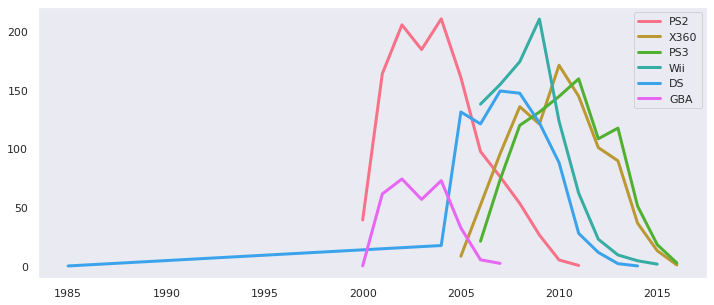

In [ ]:
# 연도별 플랫폼에따른 출고량 비교 
platform_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'GBA']
sns.set_style('dark')
sns.set_palette('husl')

fig, ax = plt.subplots(figsize = (12, 5))

for i in platform_list:
  ax.plot(dataset[dataset['Platform']==i].groupby('Year')['Total_Sales'].sum(),label = i,lw = 3)

plt.legend()

플레이스테이션2의 출시로 2000년대 초반 비디오게임 시장을 급격하게 성장했으며, 이시기에 닌텐도에서 Ds 와 GBA로 조금씩 상승곡선을 그린후  2004년을 기점으로 닌텐도사의 급격한 상승곡선과 함께 DS가 성장하면서 PS2가 하락했다. 이후 닌텐도사는 Wii까지 출시하며 2010정도까지 최고의 트랜드를 이끌었다.

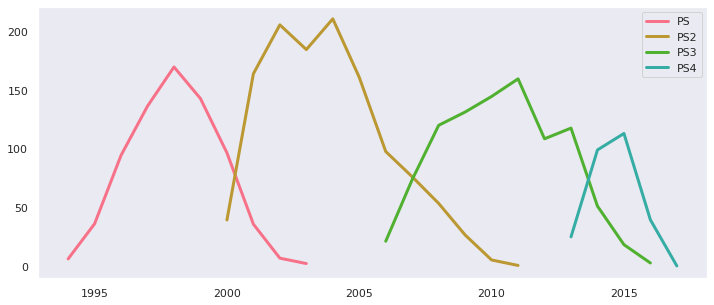

In [ ]:
# 시리즈에 따른 분석
series_list= ['PS','PS2','PS3','PS4']
sns.set_palette('husl')

fig, ax = plt.subplots(figsize = (12, 5))

for i in series_list:
  ax.plot(dataset[dataset['Platform']==i].groupby('Year')['Total_Sales'].sum(),label = i,lw = 3)

plt.legend()

PS시리즈는 꾸준한 사랑을 받아왔으며 겉으로 보기에는 PS4시리즈는 상대적으로 인기가 없어보이지만 비디오게임시장의 축소로 인한 전체적인 침체기 이므로 PS시장의 실패라고 하기 힘들다.

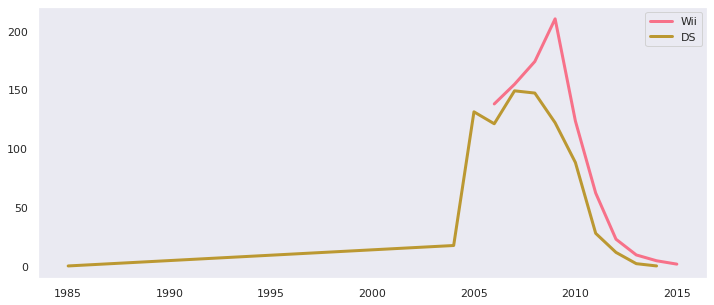

In [ ]:
# 시리즈에 따른 분석
series_list= ['Wii','DS']
sns.set_palette('husl')

fig, ax = plt.subplots(figsize = (12, 5))

for i in series_list:
  ax.plot(dataset[dataset['Platform']==i].groupby('Year')['Total_Sales'].sum(),label = i,lw = 3)

plt.legend()

닌텐도 사는 20005년 DS를 시작으로 Wii를 통해 트렌드를 이끌었지만 모바일 산업(스마트폰)의 성장으로 하락을맞이했다.


 **다음 분기 설계에 필요한 인사이트** : 가장 최근에 핫한 플랫폼은 X360이며, PS4도 좋았지만 모바일산업의 성장으로 잠깐 뜨고 하락세를 기록했다. 하지만, 이것은 비디오게임 시장자체가 가라앉은것이기 때문에 PS시리즈의 문제라고 할 근거는 보이지 않는다

#### 연도별 장르에따른 게임의 트렌드 분석

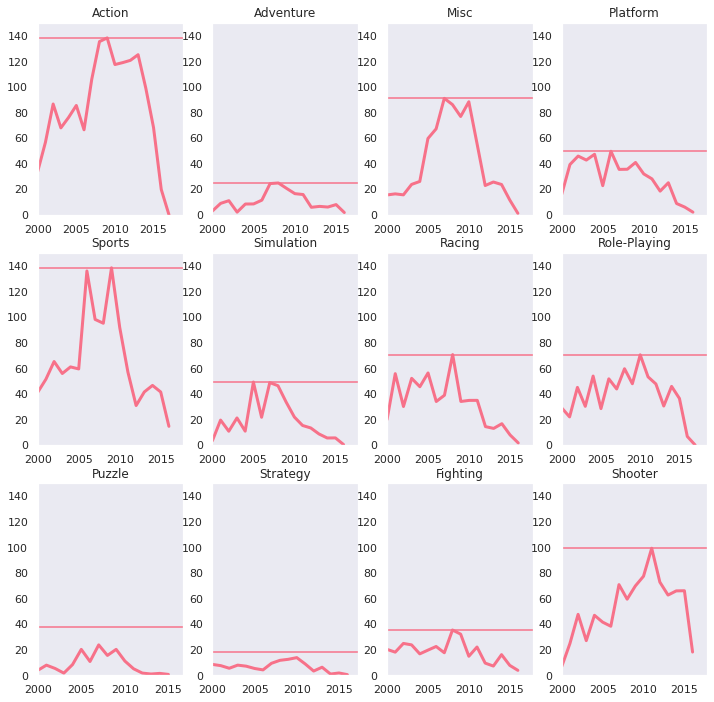

In [ ]:
# 연도별 장르에따른 비디오 게임의 트렌드 분석
sns.set_context('notebook')
sns.set_palette('husl')

genre = list(dataset['Genre'].unique())
fig, ax = plt.subplots(3,4, figsize = (12, 12))

# 행,열을 이용하기 위한 코드
for i, gen in  enumerate(genre):
  if i <= 3:
    x = 0
  elif i <= 7:
    x = 1
  elif i <= 11:
    x = 2

  y = i % 4

  df = dataset[dataset['Genre']==gen].groupby('Year')['Total_Sales'].sum()
  ax[(x, y)].plot(df,lw=3)
  ax[(x, y)].set_title(gen)
  ax[(x, y)].set_ylim(0, 150)
  ax[(x, y)].set_xlim(2000,)
  ax[(x, y)].axhline(df.max())

비디오게임 시장이 커지기 시작한 2000년대 이후에 집중하기 위해 연도 범위 제한 후  트랜드를 살펴보기

출고량의 고점이 가장높은것은 Action과 Sports이며 뒤를 이어 Misc, Shooter,Racing,Role-Playing이 높은 출고량을 보인다. 

다음 분기 설계에 필요한 인사이트 : Action과 Shooter 장르가 비디오게임의 하락세직전 가장 인기있는 장르였다.

In [ ]:
# 장르별 출고량 순위 확인
pd.DataFrame(dataset.groupby('Genre')['Total_Sales'].sum()).sort_values('Total_Sales',ascending= False)

,Total_Sales
Genre,
Action,1712.98
Sports,1305.34
Shooter,1024.75
Role-Playing,901.51
Platform,827.99
Misc,779.70
Racing,722.55
Fighting,443.54
Simulation,388.99


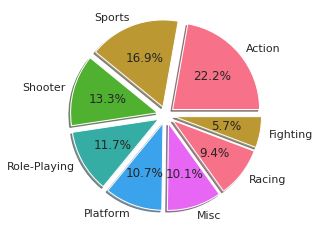

In [ ]:
sizes =[1712.98, 1305.34, 1024.75, 901.51, 827.99, 779.70, 722.55, 443.54,]
labels = ['Action', 'Sports', 'Shooter', 'Role-Playing', 'Platform', 'Misc', 'Racing', 'Fighting']
sns.set_palette('husl')

fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(sizes,
                                   labels = labels,
                                   autopct = '%1.1f%%',
                                   shadow = True,
                                   explode =(0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1, 0.1 ))



Action이 월등하게 많은 양이 출고가 되었다는것을 알 수 있다.


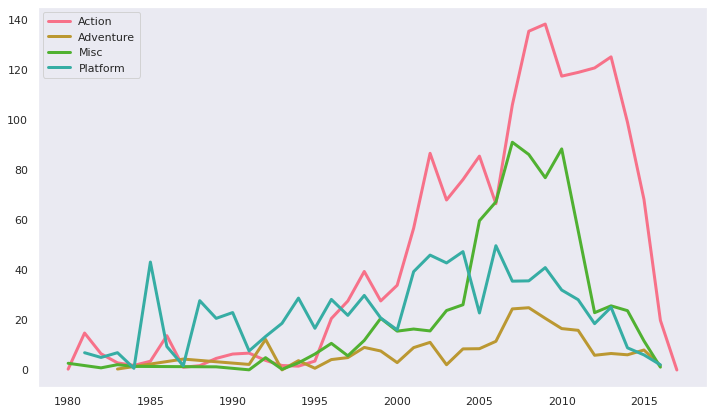

In [ ]:
fig, ax =plt.subplots(figsize = (12,7))
genre_list = list(dataset['Genre'].unique())[:4]
sns.set_palette('husl')

for i in genre_list:
  ax.plot(dataset[dataset['Genre']==i].groupby('Year')['Total_Sales'].sum(),label = i, lw =3)

plt.legend()

Action의 경우 비디오 게임이 유행하던 2000년도와 2005년 이후 가장 영향을 많이 받았으며, Adventure의 경우 소폭의 상승을 제외하면 항상 일정한 수준에 머무른다. Misic역시 2005년 상승했으며 Platform은 조금씩 상승과 하락을 반복

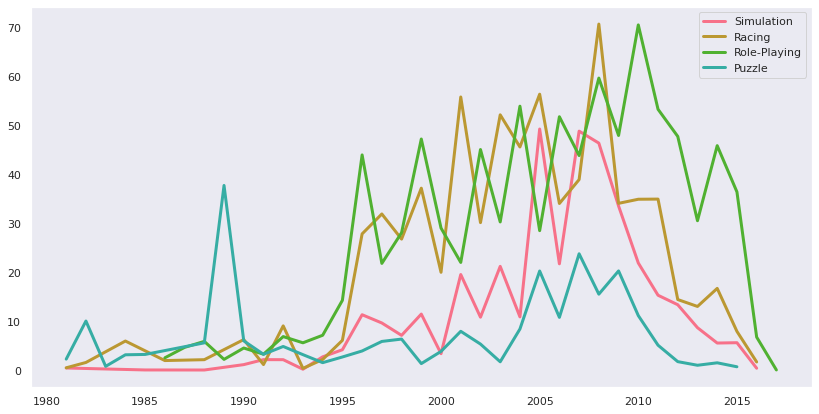

In [ ]:
fig, ax =plt.subplots(figsize = (14,7))
genre_list = list(dataset['Genre'].unique())[5:9]
sns.set_palette('husl')

for i in genre_list:
  ax.plot(dataset[dataset['Genre']==i].groupby('Year')['Total_Sales'].sum(),label = i, lw =3)

plt.legend()

Simulation은 2005년 도와 2008년도에 잠깐 상승했으며, Racing의 경우 1995년이후 계속 상승을 했으며 Role-Playing의 경우 꾸준히 많은사람들에게 소비되어 왔다. Puzzle은 80년대 후반에 잠깐 인기를 본후 이후 이시기만큼의 소비는 없었다.

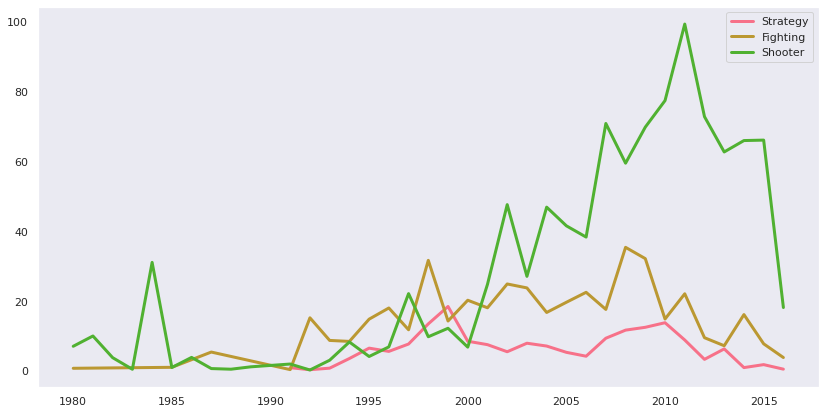

In [ ]:
fig, ax =plt.subplots(figsize = (14,7))
genre_list = list(dataset['Genre'].unique())[9:]
sns.set_palette('husl')
for i in genre_list:
  ax.plot(dataset[dataset['Genre']==i].groupby('Year')['Total_Sales'].sum(),label = i, lw =3)

plt.legend()

shooter 게임은 2000년대 이후 금격히 상승하기 시작했다. 그리고 2010년도 이후 FPS가 유행하기 시작하자 최고점을 찍게된다.

95년도를 기점으로 본격적으로 상승하기 시작한 게임들이 있다. 
Action, Racing, Role-Playing이 이에 속한다.



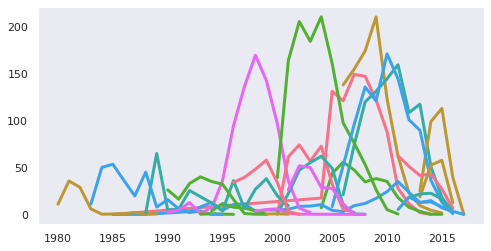

In [ ]:
# 95년이후 상승한것에 대해 플랫폼과의 연관성을 확인하기 위해 연도별 플랫폼에따른 총 출고량 확인
fig, ax = plt.subplots(figsize = (8,4))
sns.set_palette('husl')

for i in dataset['Platform'].unique():
  ax.plot(dataset[dataset['Platform']==i].groupby('Year')['Total_Sales'].sum(),label = i,lw = 3)
  


In [ ]:
dataset

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16237,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16239,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


95년대 이후 노란색 플랫폼의 상승이 두드러진다.(ps) 
해당하는 플랫폼이 비디오 게임의 시장을 확장시키기 시작한것으로 보인다.

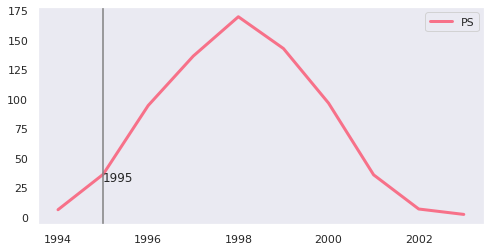

In [ ]:
# ps플랫폼 시각화
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(dataset[dataset['Platform']=='PS'].groupby('Year')['Total_Sales'].sum(),label = 'PS',lw = 3)

plt.axvline(x = 1995,color = 'gray')
plt.annotate(1995, xy=(1996,65), xytext=(1995,30))


plt.legend()

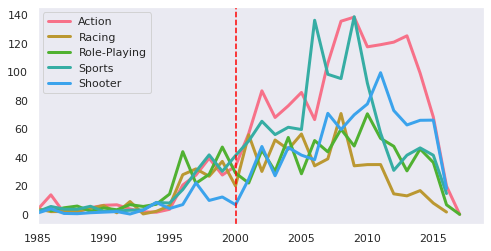

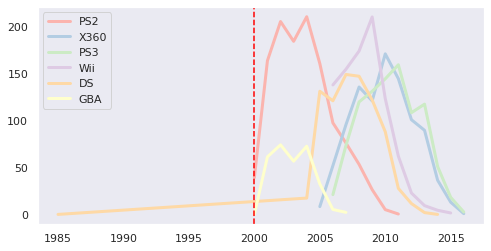

In [ ]:
# 출고량 높은 장르 확인

# 장르에 따른 연도별 출고량
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(dataset[dataset['Genre']=='Action'].groupby('Year')['Total_Sales'].sum(),label = 'Action', lw =3)
ax.plot(dataset[dataset['Genre']=='Racing'].groupby('Year')['Total_Sales'].sum(),label = 'Racing', lw =3)
ax.plot(dataset[dataset['Genre']=='Role-Playing'].groupby('Year')['Total_Sales'].sum(),label = 'Role-Playing', lw =3)
ax.plot(dataset[dataset['Genre']=='Sports'].groupby('Year')['Total_Sales'].sum(),label = 'Sports', lw =3)
ax.plot(dataset[dataset['Genre']=='Shooter'].groupby('Year')['Total_Sales'].sum(),label ='Shooter', lw =3)
ax.set_xlim(1985,)
ax.axvline(x = 2000, color = 'r',ls = '--')
sns.set_palette('husl')

plt.legend()




# 플랫폼에 따른 연도별 출고량
platform_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'GBA']
sns.set_style('dark')
sns.set_palette('Pastel1')
fig, ax = plt.subplots(figsize = (8, 4))

for i in platform_list:
  ax.plot(dataset[dataset['Platform']==i].groupby('Year')['Total_Sales'].sum(),label = i,lw = 3)

ax.axvline(x = 2000, color = 'r',ls = '--')



plt.legend()

95년도 이후 플레이스테이션이 1과 2가 연달아 나오면서  Action과 Racing 그리고 Role-Playing이 상승한 것이다. 이외에도 2000년대에는 DS와 같은 다양한 플랫폼이 등장하면서 급격한 상승이 계속해서 이어지게된다.

장르에 따른 변화는 플랫폼의 트렌드에 영향을 많이 받는것 같다.



In [ ]:
model = dataset.pivot_table(index = ['Genre'],
                    columns = ['Platform'],
                    values = ['Total_Sales'],
                    aggfunc = 'mean',fill_value = 0)
model

Total_Sales                  ...                              
Platform            2600   3DO       3DS  ...      X360        XB      XOne
Genre                                     ...                              
Action          0.478364  0.00  0.313833  ...  0.753459  0.312105  0.496765
Adventure       0.400000  0.06  0.131667  ...  0.323191  0.116154  0.226364
Fighting        0.770000  0.00  0.745714  ...  0.579531  0.290909  0.334286
Misc            0.714000  0.00  0.197547  ...  0.732459  0.190444  0.458667
Platform        1.473333  0.00  1.151786  ...  0.473750  0.196531  0.200000
Puzzle          1.708750  0.02  0.292105  ...  0.121667  0.058571  0.000000
Racing          0.580000  0.00  1.443000  ...  0.649100  0.240000  0.464737
Role-Playing    0.000000  0.00  0.730238  ...  0.959467  0.587391  0.727692
Shooter         1.043636  0.00  0.205000  ...  1.406802  0.498374  1.563333
Simulation      0.440000  0.02  0.951071  ...  0.392222  0.296250  0.180000
Sports          0.253333  0.00  0.247200  ...  0.638744  0.315427  0.666111
Strategy        0.000000  0.00  0.138000  ...  0.362593  0.130476  0.130000

[12 rows x 31 columns]

In [ ]:
chi2 = chi2_contingency(model)
if chi2[1] < 0.05:
  print("장르와 지역은 서로 연관이 있다.")
else:
  print("장르와 지역은 서로 연관이 없다.")

print(chi2[1])

장르와 지역은 서로 연관이 없다.
1.0


### 출고량이 높은 게임에 대한 분석 및 시각화

#### 출고량이 높은 게임 확인하기

In [ ]:
# 출고량이 높은 게임 확인하기
dataset.sort_values('Total_Sales', ascending=False).iloc[:50]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2855,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4113,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
12316,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3288,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
7673,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
1187,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6796,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
2959,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
16176,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
10280,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


닌텐도사의 다양한 장르의 게임이 출고량이 압도적이었다. 그만큼 닌텐도 붐이 있었음을 알 수 있다.

#### 출고량 TOP5의 연도

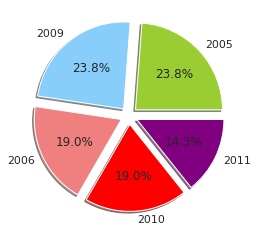

In [ ]:
# 출고량 Top5에 대한 연도

Year_Data =dataset.sort_values('Total_Sales', ascending=False).iloc[:50]['Year'].value_counts()[:5]
Year_Data


sizes = Year_Data.values
labels = Year_Data.index
group_colors = ['yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple']


patches, texts, autotexts =ax.pie(sizes,
                                  labels = labels,
                                  autopct = '%1.1f%%',
                                  shadow = True,
                                  explode = (0.1, 0.1, 0.1, 0.1, 0.1),
                                  colors = group_colors) 
ax.get_legend().remove()
display(fig)

# 아래코드는 추후 더 소프트한 코드를 위함
# Year_Data =dataset.sort_values('Total_Sales', ascending=False).iloc[:50]['Year'].value_counts()[:5]


# fig, ax = plt.subplots() 
# for i, j in enumerate(Year_Data):
#   sizes = []
#   labels = []
#   sizes = sizes.append(j)
#   labels = labels.append(i)
#   patches, texts, autotexts =ax.pie(sizes,
#                                     labels = labels,
#                                     autopct = '%1.1f%%',
#                                     shadow = True) 

2005과 2009년에 출고량이 공동으로 1등이다. 이때는 PS2와 닌텐도가 흥행할 시기랑 겹친다. 하지만 해당 데이터는 다음분기 계획에 있어서 영향을 미치지는 않는다.

In [ ]:
# Top10 출고량 데이터 불러오기
TOP_10 = dataset.sort_values('Total_Sales', ascending=False).iloc[:10]
TOP_10

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2855,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4113,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
12316,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3288,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
7673,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
1187,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6796,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
2959,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
16176,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
10280,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


출고량 TOP10의 Publisher는 모두 Nintendo이다.

#### 출고량 TOP10 게임의 플랫폼별 분석

In [ ]:
# (출고량 TOP10 게임의 플랫폼별 출고량비교) 데이터프레임 생성
TOP_10_platform = pd.DataFrame(TOP_10.groupby('Platform')['Total_Sales'].sum()).reset_index()
TOP_10_platform

,Platform,Total_Sales
0,DS,30.01
1,GB,61.64
2,NES,68.55
3,Wii,209.19


Text(0.5, 1.0, 'Top10 Sales acoording to Platform')

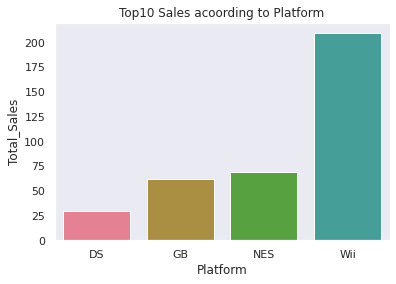

In [ ]:
# (출고량 TOP10 게임의 플랫폼별 출고량비교)시각화
sns.set_context('notebook')
sns.set_palette('husl')

sns.barplot(x =TOP_10_platform['Platform'], y = TOP_10_platform['Total_Sales'])
plt.title("Top10 Sales acoording to Platform")

출고량이 높은 게임의 경우 'Wii', 'NES', 'GB', 'DS' 의 플랫폼을 주로 사용하며 그중에서도 Wii를 가장 많이 사용한다.

압도적으로 닌텐도사의 wii가 많다.


#### 출고량 TOP10 게임의 장르별 분석

In [ ]:
# (출고량 TOP10 게임의 장르별 출고량비교) 데이터프레임 생성
TOP_10_genre = pd.DataFrame(TOP_10.groupby('Genre')['Total_Sales'].sum()).reset_index()
TOP_10_genre

,Genre,Total_Sales
0,Misc,29.01
1,Platform,98.86
2,Puzzle,30.26
3,Racing,35.83
4,Role-Playing,31.38
5,Shooter,28.31
6,Sports,115.74


Text(0.5, 1.0, 'Top10 Sales acoording to Genre')

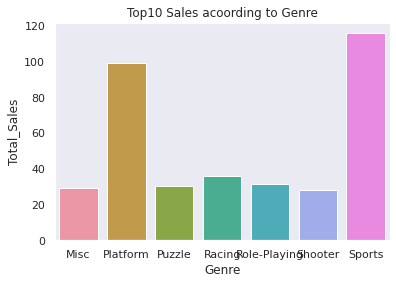

In [ ]:
# (출고량 TOP10 게임의 장르별 출고량비교) 시각화
sns.set_context('notebook')
sns.set_palette('husl')

sns.barplot(x =TOP_10_genre['Genre'], y = TOP_10_genre['Total_Sales'])
plt.title("Top10 Sales acoording to Genre")

출고량이 높은게임의 경우 Sports와 Platform장르가 가장 특징적이다.


#### 출고량 TOP10 지역별 판매량 분석

In [ ]:
# (출고량 TOP10 지역별 판매량 비교) 데이터프레임 생성
TOP_10_sales = pd.DataFrame(TOP_10.groupby(region)['Total_Sales'].sum()).reset_index()
TOP_10_sales = TOP_10_sales.sort_values('Total_Sales',ascending = False).reset_index()
TOP_10_sales.drop('index', axis =1,inplace=True)
TOP_10_sales

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,41.49,29.02,3.77,8.46,82.74
1,29.08,3.58,6.81,0.77,40.24
2,15.85,12.88,3.79,3.31,35.83
3,15.75,11.01,3.28,2.96,33.00
4,11.27,8.89,10.22,1.00,31.38
5,23.20,2.26,4.22,0.58,30.26
6,11.38,9.23,6.50,2.90,30.01
7,14.03,9.20,2.93,2.85,29.01
8,14.59,7.06,4.70,2.26,28.61
9,26.93,0.63,0.28,0.47,28.31


In [ ]:
# 데이터프레임 재구조화
region_sales = pd.melt(TOP_10_sales, id_vars=['Total_Sales'], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], value_name='Sales').sort_values('Total_Sales').reset_index()
region_sales = region_sales.drop('index',axis =1)
region_sales = region_sales.sort_index(ascending=False).reset_index()
region_sales = region_sales.drop('index',axis =1) 
region_sales

,Total_Sales,variable,Sales
0,82.74,NA_Sales,41.49
1,82.74,EU_Sales,29.02
2,82.74,JP_Sales,3.77
3,82.74,Other_Sales,8.46
4,40.24,Other_Sales,0.77
5,40.24,EU_Sales,3.58
6,40.24,NA_Sales,29.08
7,40.24,JP_Sales,6.81
8,35.83,Other_Sales,3.31
9,35.83,JP_Sales,3.79


Text(0.5, 1.0, 'Sales by reigon')

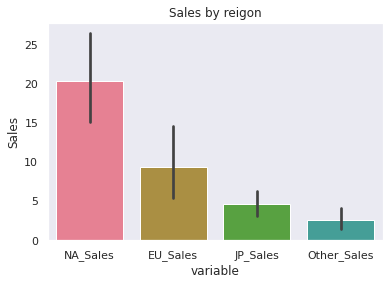

In [ ]:
# (출고량 TOP10 지역별 비교) 시각화
sns.set_context('notebook')
sns.set_palette('husl')
sns.barplot(x = region_sales['variable'], y =  region_sales['Sales'])
plt.title('Sales by reigon')

<출고량이 높은 게임에 대한 분석결과>
- 닌텐도사의 여러 장르들이 압도적인 출고량을 보여준다.
- 2005년과 2009년 플레이스테이션과 닌텐도의 출현으로 가장많은 출고량을 보여준다.
- Sports와 Platform 이 가장 비중이 높고 비중이 높다고 예상되는 액션이 등장하지 않은것으로 보아 탑10의 대부분을 차지하는 닌텐도에서 액션은 흥행하지 않은것으로 보인다.
- 미국이 압도적으로 판매량이 많은것으로 보아 비디오 게임시장은 미국이 가장큰것으로 보여진다.


### 지역별 선호하는 게임 플랫폼은 다를까?

In [ ]:
# 새로운 데이터프레임 구축
preferdata = dataset.groupby('Platform')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().sort_values(by = ['NA_Sales'], ascending = False).reset_index()
preferdata

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,X360,593.78,277.90,12.29,84.62
1,PS2,568.54,332.03,134.10,187.77
2,Wii,495.10,260.78,65.79,78.48
3,PS3,388.00,339.71,78.56,140.47
4,DS,387.66,194.05,174.97,60.22
5,PS,333.79,211.75,139.09,40.53
6,XB,179.24,58.37,1.38,8.31
7,GBA,178.26,72.43,46.56,7.51
8,N64,138.34,40.67,33.47,4.28
9,GC,131.74,38.27,20.90,5.11


In [ ]:
# 데이터프레임 재구조화
region_sales = pd.melt(TOP_10_sales, id_vars=['Total_Sales'], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], value_name='Sales').sort_values('Total_Sales').reset_index()
preferdata  = pd.melt(preferdata , id_vars=['Platform'][:6], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],value_name='Sales').reset_index().drop('index',axis =1)
preferdata

,Platform,variable,Sales
0,X360,NA_Sales,593.78
1,PS2,NA_Sales,568.54
2,Wii,NA_Sales,495.10
3,PS3,NA_Sales,388.00
4,DS,NA_Sales,387.66
...,...,...,...
119,PCFX,Other_Sales,0.00
120,NG,Other_Sales,0.00
121,GG,Other_Sales,0.00
122,TG16,Other_Sales,0.00


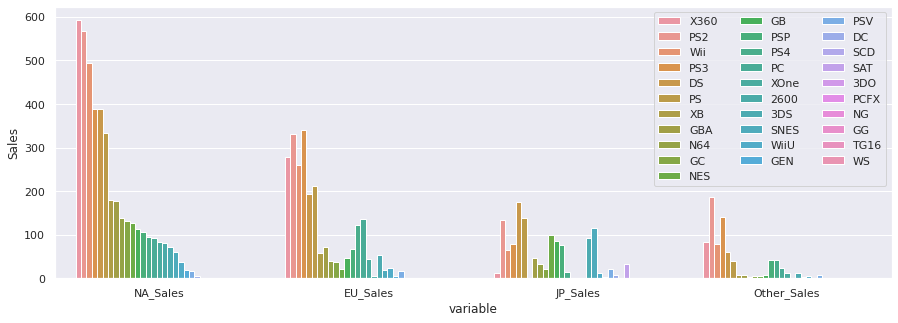

In [ ]:
# (지역별 선호하는 플렛폼) 시각화 
sns.set_context('notebook')
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(x = preferdata['variable'], y = preferdata['Sales'],hue = preferdata['Platform'])
ax.legend(loc ='upper right',ncol=len(preferdata.columns))


**< 북미>**
1. X360을 가장선호하며 유사한 수치로 PS2역시 선호하고 있다. 하지만 여기서 관과하기 쉬운것은 이전에 EDA한 연도별 플랫폼 선호도 에서 PS2는 시리즈 이기때문에 마지막 PS4 시리즈가 있었다.
2. Wii 같은경우 가장 최신까지 유행을 했었기 때문에 다음분기 계획에 고려할만 하다.


**< 유럽 >**
1. 마찬가지로 X360은 높은 수치를 보여주고 있다.
2. Wii와 DS는 고려해볼 만 하다.
3. 다른 지역에 비해 PS4의 수요가 많았기 때문에 PS4혹은 PS다음 시리즈가 나온다면 타겟팅해 볼만하다.

**< 일본 >** 
1. 일본의 경우는 DS의 비중이 높았지만 비교적 분포가 고른 모습을 보여주었기때문에 여러 플랫폼을 생각해 볼만하다.

**< 다른 지역 >**
1. X360과 PS시리즈 닌텐도가 높게나왔기 때문에 이를 바탕으로 기획해볼만 하다.

### 지역별 선호하는 장르

처음에 지역과 장르가 연관있다는 통계검정의 결과를 바탕으로 다시한번 시각화해보기

In [ ]:
prefergenre = dataset.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().sort_values(by = ['NA_Sales'], ascending = False).reset_index()
prefergenre

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Action,858.75,513.64,156.60,183.99
1,Sports,667.26,370.97,134.76,132.35
2,Shooter,574.48,310.23,38.18,101.86
3,Platform,445.38,200.63,130.53,51.45
4,Misc,394.73,208.15,104.18,72.64
5,Racing,354.70,235.02,56.32,76.51
6,Role-Playing,318.76,183.09,342.93,56.73
7,Fighting,220.35,99.90,87.14,36.15
8,Simulation,181.16,112.99,63.54,31.30
9,Puzzle,121.58,50.47,56.24,12.44


In [ ]:
# 데이터프레임 재구조화
region_sales = pd.melt(TOP_10_sales, id_vars=['Total_Sales'], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], value_name='Sales').sort_values('Total_Sales').reset_index()
prefergenre  = pd.melt(prefergenre , id_vars=['Genre'][:6], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],value_name='Sales').reset_index().drop('index',axis =1)
prefergenre

,Genre,variable,Sales
0,Action,NA_Sales,858.75
1,Sports,NA_Sales,667.26
2,Shooter,NA_Sales,574.48
3,Platform,NA_Sales,445.38
4,Misc,NA_Sales,394.73
5,Racing,NA_Sales,354.70
6,Role-Playing,NA_Sales,318.76
7,Fighting,NA_Sales,220.35
8,Simulation,NA_Sales,181.16
9,Puzzle,NA_Sales,121.58


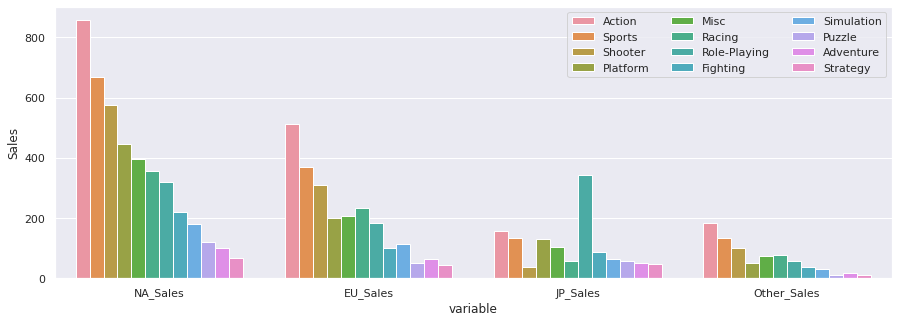

In [ ]:
# (지역별 선호하는 플렛폼) 시각화 
sns.set_context('notebook')
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(x = prefergenre['variable'], y = prefergenre['Sales'],hue = prefergenre['Genre'])
ax.legend(loc ='upper right',ncol=len(prefergenre.columns))

< 북미 >
- Action, Sports, Shooter, Platform 순서대로 선호

< 유럽 >
- Action, Sports, Shooter, Racing 순서대로 선호

< 일본 >
- Role-Playing이 압도적이고 다비슷하다(다만, Shooter가 가장 저조)

< 다른지역 >
- Action, Sports, Shooter순서이며 나머지는 다비슷

### 다음분기 게임 설계를 위한 최근데이터 분석

**2010년 이후 플랫폼에 따른 평균출고량**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Platform', ylabel='Total_Sales'>

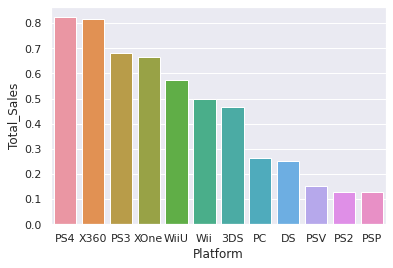

In [ ]:
Recent_platform = pd.DataFrame(dataset[dataset['Year'] >= 2010].groupby(dataset['Platform'])['Total_Sales'].mean()).sort_values('Total_Sales', ascending= False)
Recent_platform = Recent_platform.reset_index()
Recent_platform

sns.set_context('notebook')
sns.barplot(Recent_platform['Platform'], Recent_platform['Total_Sales'])

**2010년 이후 장르에 따른 평균 출고량**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


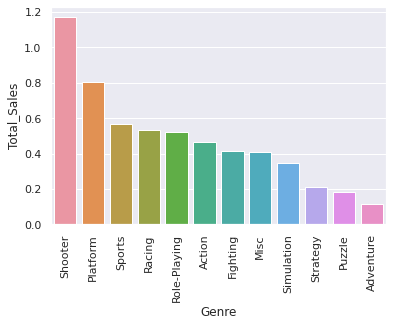

In [ ]:
Recent_genre = pd.DataFrame(dataset[dataset['Year'] >= 2010].groupby(dataset['Genre'])['Total_Sales'].mean()).sort_values('Total_Sales', ascending= False)
Recent_genre = Recent_genre.reset_index()
Recent_genre

sns.set_context('notebook');
sns.barplot(Recent_genre['Genre'], Recent_genre['Total_Sales']);
plt.xticks(rotation = 90);

**2010년 이후 지역에 따른 평균 출고량**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


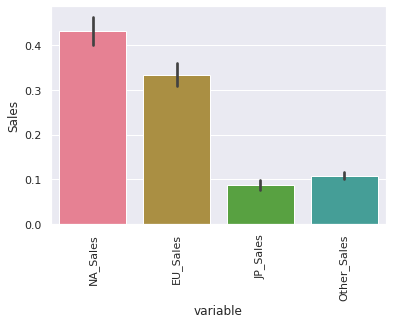

In [ ]:
Recent_region = pd.DataFrame(dataset[dataset['Year'] >= 2010].groupby(region)['Total_Sales'].mean()).reset_index()
Recent_region = Recent_region.sort_values('Total_Sales',ascending=False).reset_index().drop('index',axis = 1)
Recent_region

Recent_region = pd.melt(Recent_region, id_vars=['Total_Sales'], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], value_name='Sales').sort_values('Total_Sales')
Recent_region = Recent_region.reset_index().drop('index',axis = 1)
Recent_region = Recent_region.sort_values('Sales', ascending=False)
Recent_region

sns.set_context('notebook');
sns.set_palette('husl')

sns.barplot(Recent_region ['variable'], Recent_region ['Sales']);
plt.xticks(rotation = 90);

# 결론

< 지역별 비디오게임 설계 >
- 1. 북미 지역에 X360으로 Action 혹은  Sports 장르 설계하기(PS4는 유럽이 가장수요가 높기때문에 제외)

- 2. 유럽지역에 X360, PS4를 통해 Action, Sports 설계하기 (닌텐도 역시 높은 수치이지만 X360이 가장인기가 있고 PS4는 유럽지역에서 가장높기때문에 닌텐도는 제외)

- 3. 일본은 닌텐도 DS를 통해 롤플레잉 설계하기.

- 4. 다른지역은 X360 혹은 PS4로 액션과 스포츠 설계하기.